In [115]:
import numpy as np
import pandas as pd

import itertools

import torch
import torch.nn as nn
import torch.optim as optim

from hypll import nn as hnn
from hypll.tensors import TangentTensor
from hypll.optim import RiemannianAdam
from hypll.manifolds.poincare_ball import Curvature, PoincareBall

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

In [116]:
import sys
sys.path.append('../')
import util

In [146]:
# FILE = '../data/arc_final_des.csv'
# FILE = '../data/arc_final_fin.csv'
FILE = '../data/arc_final_ms_spec.csv'

data = pd.read_csv(FILE, index_col=0)

data

,Floral,Fruity,Herbal,Green,Woody,Sweet,Balsamic,Earth,Spicy,Chemical,...,334,335,336,337,338,339,340,341,342,343
107,0,0,0,0,0,1,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
126,0,0,0,0,1,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
177,0,0,0,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
179,0,0,0,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
240,0,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5372353,0,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5372813,0,0,1,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5373729,1,0,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6040503,1,0,0,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [147]:
NUM_LABEL_COLS = 12
FEATURE_COLS = data.columns[NUM_LABEL_COLS:]
LABEL_COLS = data.columns[:NUM_LABEL_COLS]
print(FEATURE_COLS)
print(LABEL_COLS)

X = data[FEATURE_COLS].values
y = data[LABEL_COLS].values

X.shape, y.shape

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '334', '335', '336', '337', '338', '339', '340', '341', '342', '343'],
      dtype='object', length=344)
Index(['Floral', 'Fruity', 'Herbal', 'Green', 'Woody', 'Sweet', 'Balsamic',
       'Earth', 'Spicy', 'Chemical', 'Animalic', 'Nutty'],
      dtype='object')


((1045, 344), (1045, 12))

In [148]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)
train_X.shape, test_X.shape, train_y.shape, test_y.shape

((836, 344), (209, 344), (836, 12), (209, 12))

In [149]:
# Define custom PyTorch dataset
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

<h1> Hyperbolic </h1>

In [150]:
# Define your MLP model
class HYP_MLP(nn.Module):
    def __init__(self, input_size, output_size, layer_size, num_hidden_layers, manifold):
        super(HYP_MLP, self).__init__()
        torch.manual_seed(42)
        self.fc_in = hnn.HLinear(input_size, layer_size, manifold=manifold)
        self.relu = hnn.HReLU(manifold=manifold)
        self.hidden_fcs = nn.ModuleList([hnn.HLinear(layer_size, layer_size, manifold=manifold) for _ in range(num_hidden_layers)])
        self.fc_out = hnn.HLinear(layer_size, output_size, manifold=manifold)

    def forward(self, x):
        x = self.fc_in(x)
        x = self.relu(x)
        for fc in self.hidden_fcs:
            x = fc(x)
            x = self.relu(x)
        x = self.fc_out(x)

        return x


# Define training function
def hyp_train_model(model, train_loader, criterion, optimizer, manifold, device):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()

        tangents = TangentTensor(data=inputs, man_dim=-1, manifold=manifold)
        manifold_inputs = manifold.expmap(tangents)

        outputs = model(manifold_inputs)

        loss = criterion(outputs.tensor, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    return running_loss / len(train_loader.dataset)

<h1> EUCLIDEAN </h1>

In [151]:
# Define your MLP model
class EUC_MLP(nn.Module):
    def __init__(self, input_size, output_size, layer_size, num_hidden_layers):
        super(EUC_MLP, self).__init__()
        torch.manual_seed(42)
        self.fc_in = nn.Linear(input_size, layer_size)
        self.relu = nn.ReLU()
        self.hidden_fcs = nn.ModuleList([nn.Linear(layer_size, layer_size) for _ in range(num_hidden_layers)])
        self.fc_out = nn.Linear(layer_size, output_size)

    def forward(self, x):
        x = self.fc_in(x)
        x = self.relu(x)
        for fc in self.hidden_fcs:
            x = fc(x)
            x = self.relu(x)
        x = self.fc_out(x)

        return x

# Define training function
def euc_train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    return running_loss / len(train_loader.dataset)

In [33]:
param_grid = {
    'model_type': ['hyp', 'euc'],
    'num_hidden_layers': [1,2,4,8,16],
    'layer_size': [2,4,8,16,32,64,128,256,512],
    'lr': [0.05,0.01,0.02],
    'weight_decay': [0.002,0.005,0.01,0.02],
    'batch_size': [1024],
    'epochs': [100],
    'curvature': [-1]
}

param_combinations = list(itertools.product(*param_grid.values()))
len(param_combinations)

1080

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

param_eval_stats = []

for i, params in enumerate(param_combinations):
    print(f'----- Combination {i} -----')
    print(*zip(param_grid.keys(), params))
    model_type, num_hidden_layers, layer_size, lr, weight_decay, batch_size, epochs, curvature = params

    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    for fold, (fold_train_indices, fold_val_indices) in enumerate(kf.split(train_X, train_y)):
        print(f'Fold {fold}')

        fold_train_X = train_X[fold_train_indices]
        fold_train_y = train_y[fold_train_indices]
        fold_val_X   = train_X[fold_val_indices]
        fold_val_y   = train_y[fold_val_indices]

        train_dataset = CustomDataset(fold_train_X, fold_train_y)
        val_dataset = CustomDataset(fold_val_X, fold_val_y)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)

        if model_type == 'hyp':
            manifold = PoincareBall(c=Curvature(curvature))
        elif model_type == 'euc':
            manifold = None

        if model_type == 'hyp':
            model = HYP_MLP(input_size=len(FEATURE_COLS),
                            output_size=len(LABEL_COLS),
                            layer_size=layer_size,
                            num_hidden_layers=num_hidden_layers,
                            manifold=manifold).to(device)
        elif model_type == 'euc':
            model = EUC_MLP(input_size=len(FEATURE_COLS),
                            output_size=len(LABEL_COLS),
                            layer_size=layer_size,
                            num_hidden_layers=num_hidden_layers).to(device)

        criterion = nn.CrossEntropyLoss()

        if model_type == 'hyp':
            optimizer = RiemannianAdam(model.parameters(), lr=lr, weight_decay=weight_decay)
        elif model_type == 'euc':
            optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

        eval_stats = {'loss': {'train': [], 'val': []},
                      'acc': {'train': [], 'val': []},
                      'aps': {'train': [], 'val': []}
                      }

        for epoch in range(epochs):
            if model_type == 'hyp':
                eval_stats['loss']['train'].append(hyp_train_model(model, train_loader, criterion, optimizer, manifold, device))

                acc, aps = util.h_evaluate_acc_aps(model, val_loader, manifold, device)
                eval_stats['acc']['val'].append(acc)
                eval_stats['aps']['val'].append(aps)
            elif model_type == 'euc':
                eval_stats['loss']['train'].append(euc_train_model(model, train_loader, criterion, optimizer, device))

                acc, aps = util.evaluate_acc_aps(model, val_loader, device)
                eval_stats['acc']['val'].append(acc)
                eval_stats['aps']['val'].append(aps)

        print(eval_stats['acc']['val'])
        print(eval_stats['aps']['val'])
        param_eval_stats.append(eval_stats)

In [ ]:
acc_values = np.array([s['acc']['val'] for s in param_eval_stats])
aps_values = np.array([s['aps']['val'] for s in param_eval_stats])

<h1>BEST MODELS</h1>

In [152]:
# meanAPS = 0.476
# meanAPS = 0.479 (1024)
hyp_des = {
    'model_type': 'hyp',
    'num_hidden_layers': 1,
    'layer_size': 512,
    'lr': 0.01,
    'weight_decay': 0.002,
    'batch_size': 1024,
    'epochs': 50,
    'curvature': -1
}

# meanAPS = 0.439
euc_des = {
    'model_type': 'euc',
    'num_hidden_layers': 1,
    'layer_size': 128,
    'lr': 0.01,
    'weight_decay': 0.01,
    'batch_size': 1024,
    'epochs': 50,
    'curvature': -1
}


# meanAPS = 0.470
# meanAPS = 0.478 (1024)
hyp_fin = {
    'model_type': 'hyp',
    'num_hidden_layers': 1,
    'layer_size': 512,
    'lr': 0.01,
    'weight_decay': 0.002,
    'batch_size': 1024,
    'epochs': 100,
    'curvature': -1
}

# meanAPS = 0.456
euc_fin = {
    'model_type': 'euc',
    'num_hidden_layers': 1,
    'layer_size': 128,
    'lr': 0.01,
    'weight_decay': 0.02,
    'batch_size': 1024,
    'epochs': 100,
    'curvature': -1
}


# meanAPS = 0.355
# meanAPS = 0.350 (1024)
hyp_ms_spec = {
    'model_type': 'hyp',
    'num_hidden_layers': 1,
    'layer_size': 512,
    'lr': 0.02,
    'weight_decay': 0.002,
    'batch_size': 1024,
    'epochs': 100,
    'curvature': -1
}

# meanAPS = 0.325
euc_ms_spec = {
    'model_type': 'euc',
    'num_hidden_layers': 1,
    'layer_size': 128,
    'lr': 0.01,
    'weight_decay': 0.002,
    'batch_size': 1024,
    'epochs': 100,
    'curvature': -1
}

In [153]:
test_stats = []

In [156]:
params = {
    'model_type': 'hyp',
    'num_hidden_layers': 1,
    'layer_size': 1024,
    'lr': 0.02,
    'weight_decay': 0.002,
    'batch_size': 1024,
    'epochs': 200,
    'curvature': -1
}

In [157]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



model_type, num_hidden_layers, layer_size, lr, weight_decay, batch_size, epochs, curvature = params.values()

fold_train_X = train_X
fold_train_y = train_y
fold_val_X   = test_X
fold_val_y   = test_y

train_dataset = CustomDataset(fold_train_X, fold_train_y)
val_dataset = CustomDataset(fold_val_X, fold_val_y)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

if model_type == 'hyp':
    manifold = PoincareBall(c=Curvature(curvature))
elif model_type == 'euc':
    manifold = None

if model_type == 'hyp':
    model = HYP_MLP(input_size=len(FEATURE_COLS),
                    output_size=len(LABEL_COLS),
                    layer_size=layer_size,
                    num_hidden_layers=num_hidden_layers,
                    manifold=manifold).to(device)
elif model_type == 'euc':
    model = EUC_MLP(input_size=len(FEATURE_COLS),
                    output_size=len(LABEL_COLS),
                    layer_size=layer_size,
                    num_hidden_layers=num_hidden_layers).to(device)

criterion = nn.CrossEntropyLoss()

if model_type == 'hyp':
    optimizer = RiemannianAdam(model.parameters(), lr=lr, weight_decay=weight_decay)
elif model_type == 'euc':
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

eval_stats = {'loss': {'train': [], 'val': []},
                'acc': {'train': [], 'val': []},
                'aps': {'train': [], 'val': []}
                }

for epoch in range(epochs):
    if model_type == 'hyp':
        eval_stats['loss']['train'].append(hyp_train_model(model, train_loader, criterion, optimizer, manifold, device))

        acc, aps = util.h_evaluate_acc_aps(model, val_loader, manifold, device)
        eval_stats['acc']['val'].append(acc)
        eval_stats['aps']['val'].append(aps)
    elif model_type == 'euc':
        eval_stats['loss']['train'].append(euc_train_model(model, train_loader, criterion, optimizer, device))

        acc, aps = util.evaluate_acc_aps(model, val_loader, device)
        eval_stats['acc']['val'].append(acc)
        eval_stats['aps']['val'].append(aps)

print(eval_stats['acc']['val'])
print(eval_stats['aps']['val'])
# test_stats.append(eval_stats)
test_stats.append(np.array(eval_stats['aps']['val']))

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.004784688995215311, 0.004784688995215311, 0.004784688995215311, 0.004784688995215311, 0.004784688995215311, 0.004784688995215311, 0.004784688995215311, 0.004784688995215311, 0.004784688995215311, 0.004784688995215311, 0.004784688995215311, 0.004784688995215311, 0.004784688995215311, 0.0, 0.0, 0.0, 0.004784688995215311, 0.004784688995215311, 0.009569377990430622, 0.009569377990430622, 0.009569377990430622, 0.009569377990430622, 0.009569377990430622, 0.004784688995215311, 0.014354066985645933, 0.0, 0.0, 0.004784688995215311, 0.0, 0.0, 0.004784688995215311, 0.004784688995215311, 0.0, 0.0, 0.004784688995215311, 0.0, 0.004784688995215311, 0.009569377990430622, 0.0, 0.009569377990430622, 0.009569377990430622, 0.0, 0.004784688995215311, 0.0, 0.0, 0.004784688995215311, 0.0, 0.0, 0.0, 0.0, 

In [158]:
test_stats[-1].shape

(200, 12)

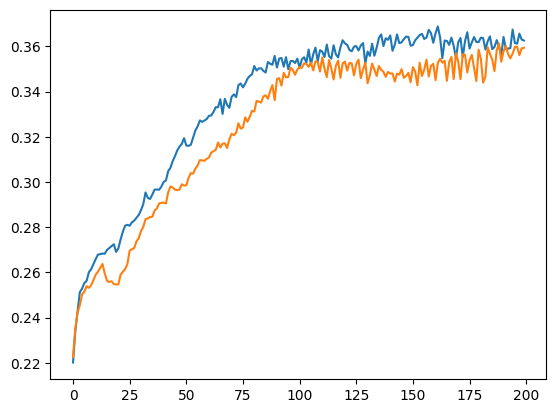

In [159]:
import matplotlib.pyplot as plt

for stats in test_stats:
    plt.plot(stats.mean(axis=1))

plt.show()

In [160]:
for stats in test_stats:
    print(stats.mean(axis=1)[99], stats.mean(axis=1)[-1])

0.35459722616522904 0.3625949761027611
0.34978163766569464 0.35938298209675895
